# Data Exploration

---

#### 1. **Imports**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

#### 2. **Load Data**

In [2]:
# Load dataset
df = pd.read_csv("paediatrics_train.csv", index_col="date", parse_dates=True)

# Ensure correct frequency (daily)
df.index.freq = 'D'

#### 3. **Describe the Data**

In [ ]:
# Rename target variable
df.rename(columns={"paed_ed_attends": "y"}, inplace=True)

# Quick inspection
print(df.info())
print(df.describe())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1056 entries, 2014-04-01 to 2017-02-19
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   y       1056 non-null   int64
dtypes: int64(1)
memory usage: 16.5 KB
None
                 y
count  1056.000000
mean     49.428977
std       9.459851
min      21.000000
25%      43.000000
50%      49.000000
75%      56.000000
max      85.000000


,y
date,
2014-04-01,47
2014-04-02,46
2014-04-03,47
2014-04-04,48
2014-04-05,52


---

#### 4. **Raw Data** - Raw data to look at overall trends and patterns

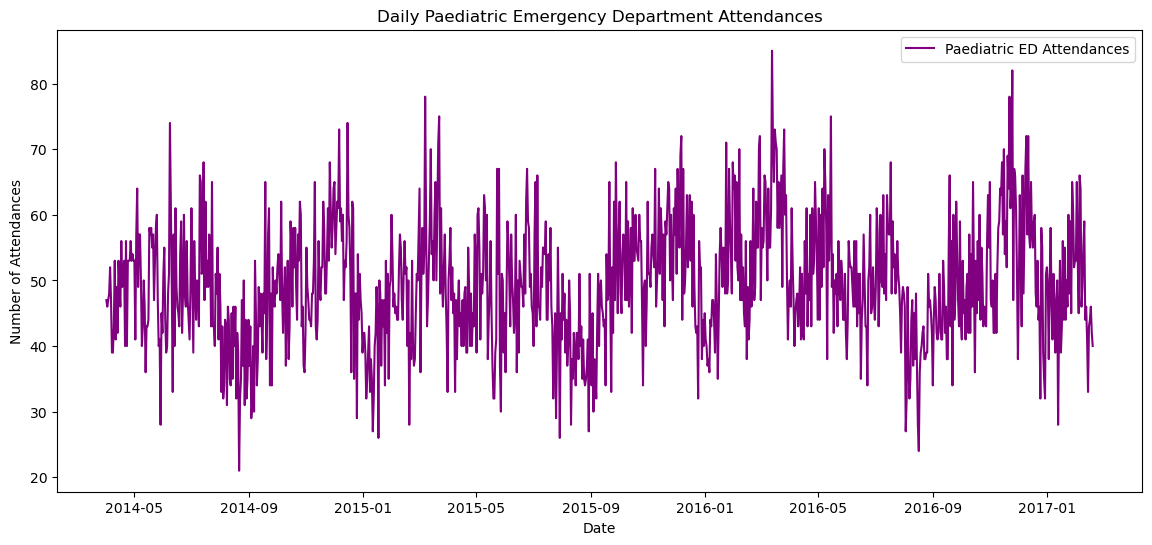

In [4]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["y"], color='purple', label="Paediatric ED Attendances")
plt.title("Daily Paediatric Emergency Department Attendances")
plt.xlabel("Date")
plt.ylabel("Number of Attendances")
plt.legend()
plt.show()

---

#### 5. **Monthly & Weekly Seasonality** - Helps visualise how attendances vary over months and days of the week

**Monthly Seasonailty Observations**:
- The boxplots are showing that the month of March, November and December
exhibit higher attendance rates when compared to other months within the year.
This could be associated with seasonal illnesses and also perhaps holiday
periods over the winter months.

**Weekly Seasonailty Observations**:
- The boxplots for the weekly observations are showing that Sundays and Mondays
appear to have a slightly higher attendance rate compared to the other days.
This could be associated with weekend-related injury's.



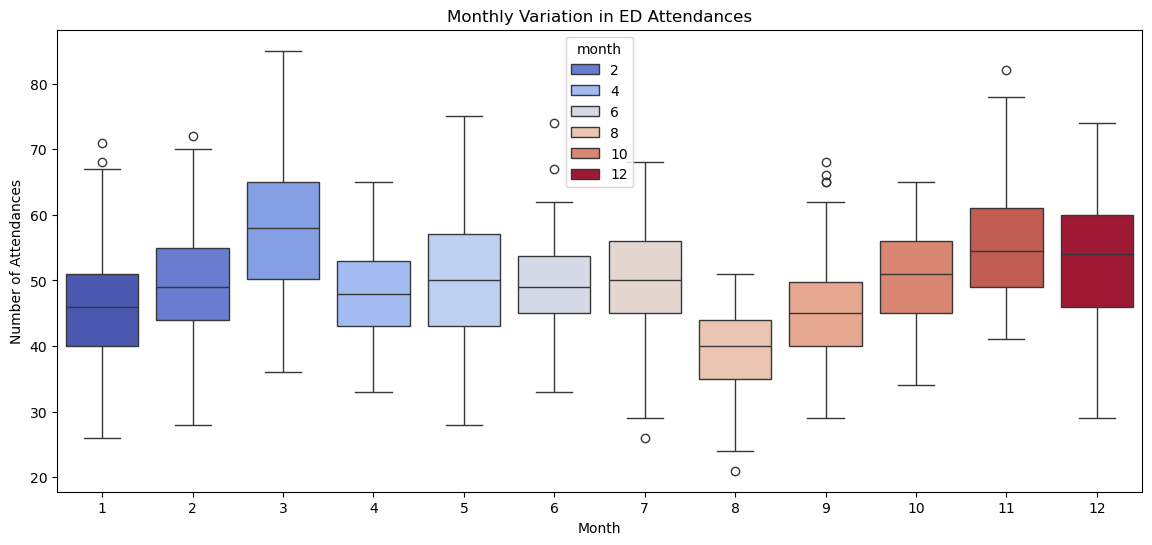

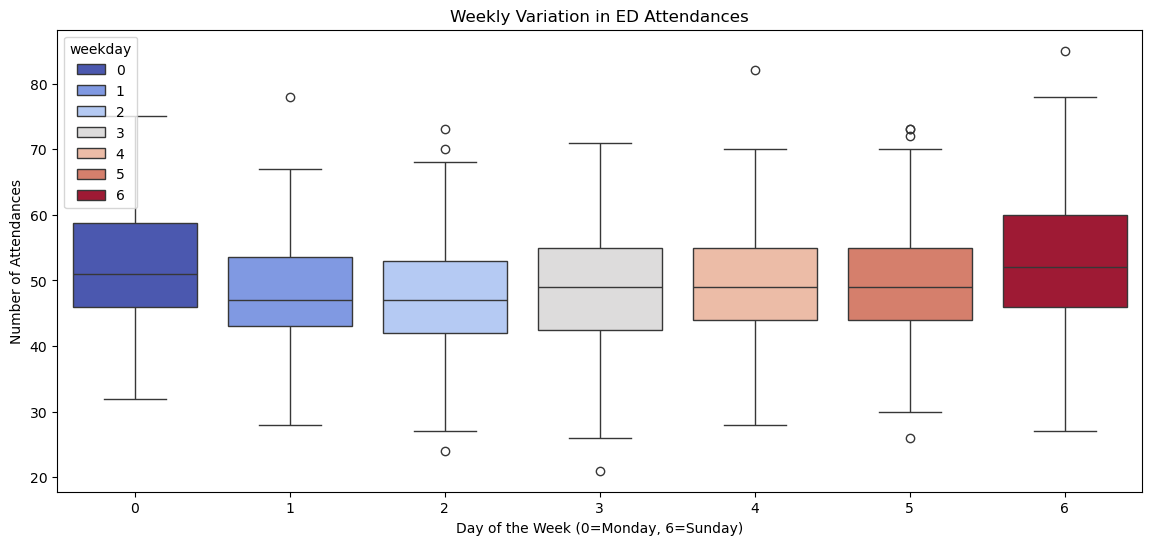

In [5]:
df["month"] = df.index.month
df["weekday"] = df.index.weekday

# Boxplot for Monthly Seasonality
plt.figure(figsize=(14, 6))
sns.boxplot(x="month", y="y", hue="month", data=df, palette="coolwarm")
plt.title("Monthly Variation in ED Attendances")
plt.xlabel("Month")
plt.ylabel("Number of Attendances")
plt.show()

# Boxplot for Weekly Seasonality
plt.figure(figsize=(14, 6))
sns.boxplot(x="weekday", y="y", hue="weekday", data=df, palette="coolwarm")
plt.title("Weekly Variation in ED Attendances")
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Number of Attendances")
plt.show()

#### 6. **Decomposing Seasonality and Trend Using MSTL** - Trend, Seasonal Components, Residual

- The raw time series plotted at the top appears to show
fluctuations over time with peaks and troughs. It looks as though there are
some weekly and monthly seasonality present within the data.
- Overall, there is no sudden and dramatic change in the number of attendances
and looks to be relatively stable over the years.

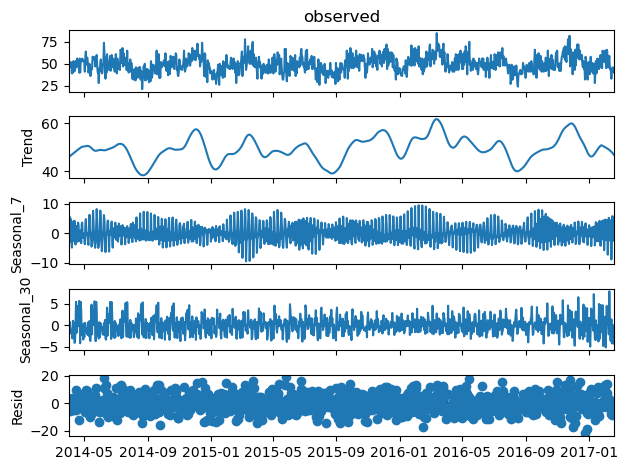

In [6]:
# Apply MSTL (Decomposition into Trend, Seasonality, Residual)
mstl = MSTL(df["y"], periods=[7, 30])  # Weekly & Monthly seasonality
res = mstl.fit()

# Plot the decomposed components
res.plot()
plt.show()

---

#### 7. **AutoCorrelation & Partial AutoCorrelation (ACF/PACF)** - Help identify ARIMA parameters (lags)

**ACF Plot**: 
- This shows significant correlation at multiple lags however, this
does seem to decay overtime. This suggests that past values strongley influence
future values, solidifying that this shows a non-random pattern in the data.

**PACF Plot**: 
- Shows strong auto correlation at lag 1, indicating that the previous days
attendances are a strong predictor of the next.

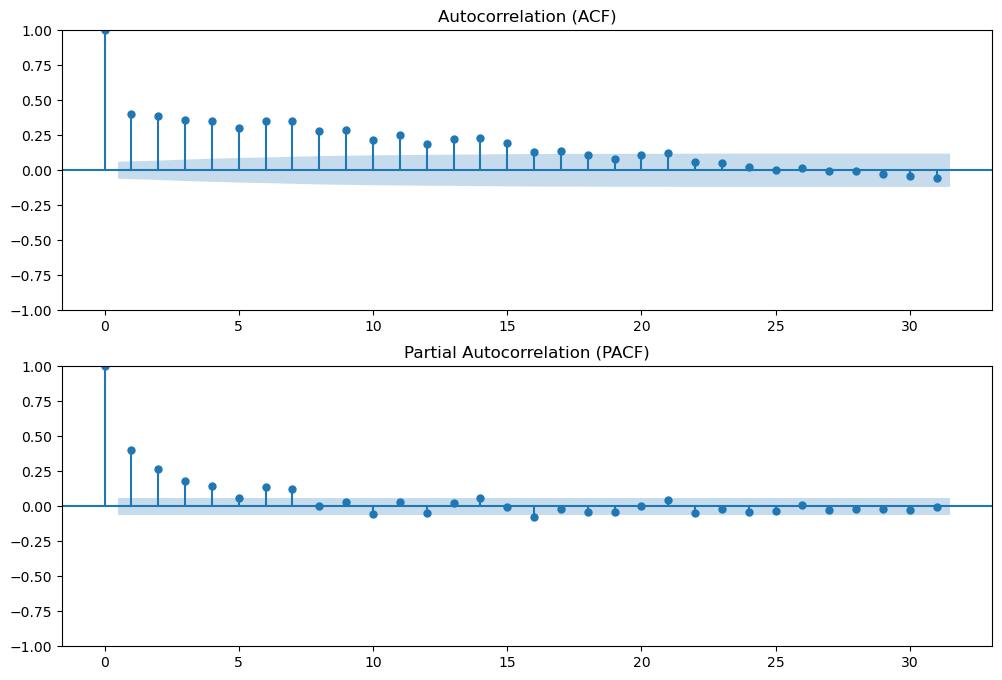

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(df["y"], ax=ax[0])
ax[0].set_title("Autocorrelation (ACF)")

plot_pacf(df["y"], ax=ax[1])
ax[1].set_title("Partial Autocorrelation (PACF)")

plt.show()

---

#### 8. **Detecting Outliers & Variability**

- This boxplot shows where most attendances fall and where the outliers are 
found. Most attendances look to be around the 42 - 58 mark. There are some
 outliers on the lower end of the scale sat around 20, this could be due to
 many external factors such as public holidays etc. 
- On the other hand there are some high outliers in the data sitting around the
 75 - 88 mark. There can be many reasons for this such as seasonal peaks, major
  incidents or week day/weekend spikes.

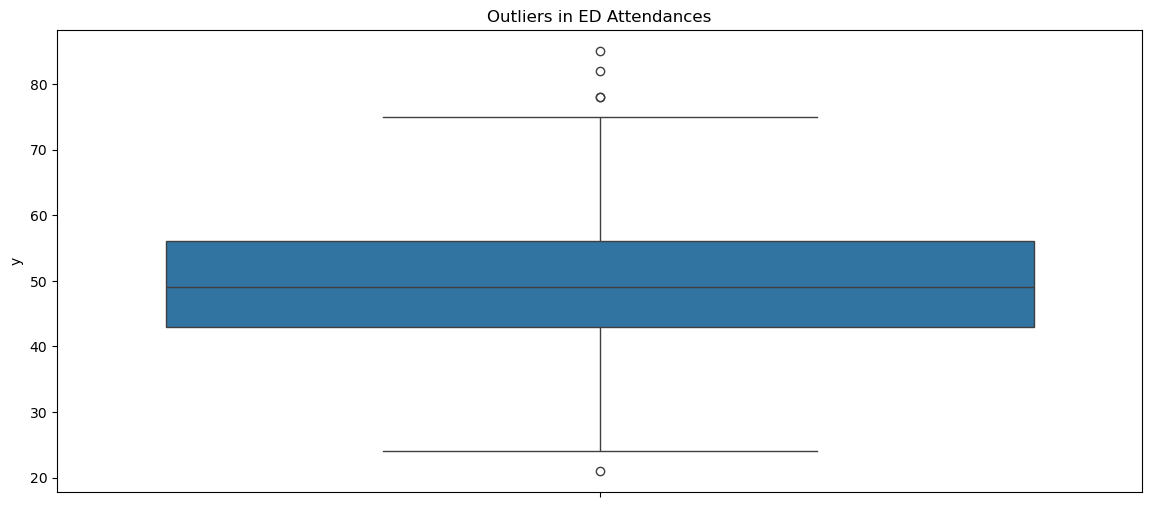

In [8]:
plt.figure(figsize=(14, 6))
sns.boxplot(y=df["y"])
plt.title("Outliers in ED Attendances")
plt.show()

**Augmented Dickey-Fuller & Kwiatkowski-Phillips-Schmidt-Shin Test**:
- These two tests help determin whether or not the data is stationary or
non-stationary. A highly negative value suggests stationarity. In addition, the
KPSS test also checks for trend stationarity, the results also supports that
the data is stationary.

In [9]:
# ADF Test (Null Hypothesis: Data is Non-Stationary)
adf_result = adfuller(df["y"])
print(f"ADF Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}")

# KPSS Test (Null Hypothesis: Data is Stationary)
kpss_result = kpss(df["y"], regression='c', nlags="auto")
print(f"KPSS Statistic: {kpss_result[0]:.4f}, p-value: {kpss_result[1]:.4f}")

ADF Statistic: -5.1146, p-value: 0.0000
KPSS Statistic: 0.3399, p-value: 0.1000


C:\Users\haydockk\AppData\Local\Temp\ipykernel_32580\1665204324.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df["y"], regression='c', nlags="auto")


---

#### 9. **Annual Comparison** - Years Stacked

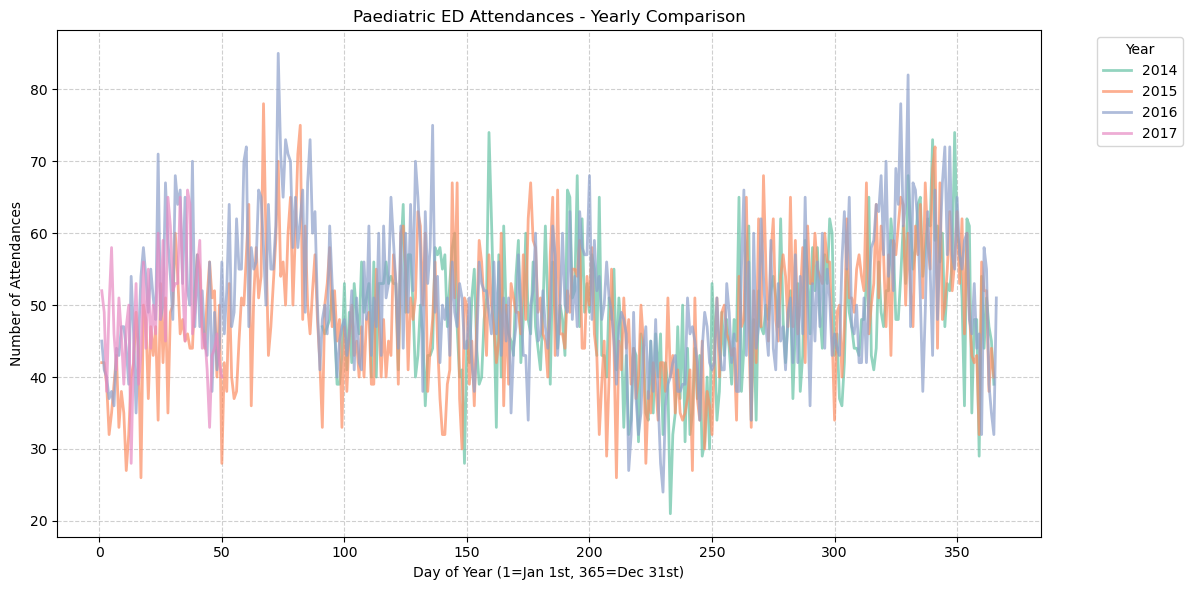

In [ ]:
# Extract Year & Day of Year
df["year"] = df.index.year
df["day_of_year"] = df.index.dayofyear

# Create a distinct color palette for the lines
colors = sns.color_palette("Set2", n_colors=len(df["year"].unique()))

# Plot each year in the same figure
plt.figure(figsize=(12, 6))

for idx, year in enumerate(df["year"].unique()):
    yearly_data = df[df["year"] == year]
    plt.plot(yearly_data["day_of_year"],
             yearly_data["y"],
             label=str(year),
             color=colors[idx],
             linewidth=2,
             linestyle='-',
             alpha=0.7)

plt.title("Paediatric ED Attendances - Yearly Comparison")
plt.xlabel("Day of Year (1=Jan 1st, 365=Dec 31st)")
plt.ylabel("Number of Attendances")

# Display the legend
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()

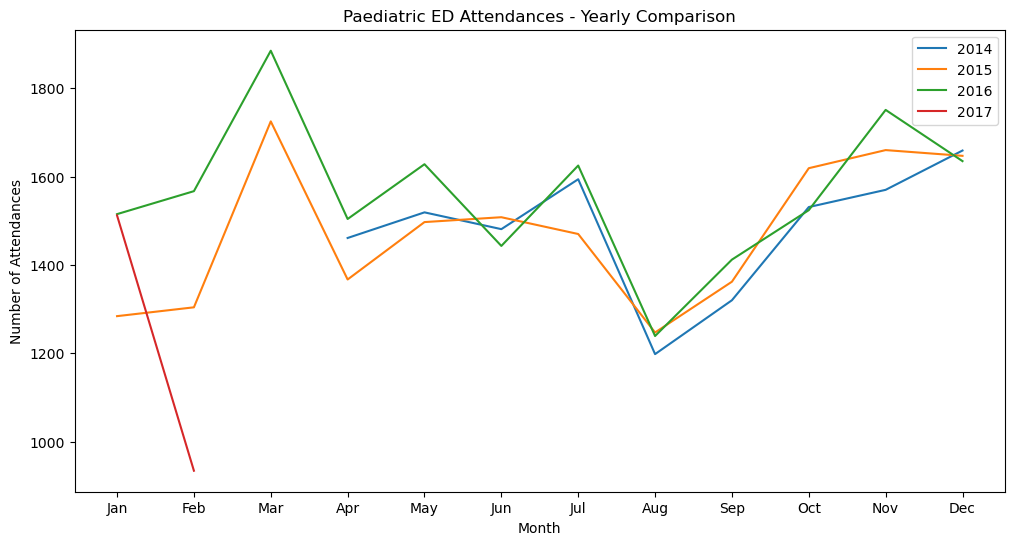

In [11]:
# Extract Year & Month
df["year"] = df.index.year
df["month"] = df.index.month

# Plot each year in the same figure
plt.figure(figsize=(12, 6))

for year in df["year"].unique():
    yearly_data = df[df["year"] == year]
    monthly_data = yearly_data.groupby("month")["y"].sum()  # Summing by month

    # Plot with months on the x-axis
    plt.plot(monthly_data.index, monthly_data, label=str(year))

plt.title("Paediatric ED Attendances - Yearly Comparison")
plt.xlabel("Month")
plt.ylabel("Number of Attendances")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul",
                          "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend()
plt.show()

#### **Key Observations from Graph Above:**

**Consistent Seasonal Patterns**
- Each year follows a similar structure, suggesting strong seasonality.
- Attendances seem higher in winter months (early & late in the year).

**Fluctuations But No Major Trend Shift**
- No obvious increasing or decreasing trend across years.
- This means ARIMA (which assumes stationarity) could work well.

**Some Annual Variability**
- Certain years (e.g., 2016) appear to have slightly higher peaks.
- There are fluctuations, but overall trends are similar.

<i>Page 2</i>